In [2]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# Load dataset
data = pd.read_excel(r'C:\Users\John\Downloads\Universidad\WorkShop0_Tabular_Data/kc_house_data_yr.xlsx')

# Features and target
X = data.drop("price", axis=1).values
y = data["price"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a model builder for Keras Tuner
def model_builder(hp):
    model = keras.Sequential()
    
    # Choose number of layers between 1-3
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'))
        
        # Optionally add dropout
        if hp.Boolean(f'dropout_{i}'):
            model.add(layers.Dropout(rate=hp.Choice(f'dropout_rate_{i}', [0.2, 0.3, 0.4])))

    # Output layer for regression
    model.add(layers.Dense(1, activation='linear'))

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse',
                  metrics=['mae'])
    
    return model

# Initialize tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_mae',
    max_trials=5,  # number of hyperparameter settings to try
    executions_per_trial=2,  # run each model more than once for robustness
    directory='house_tuning',
    project_name='kc_house_regression'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Units layer {i}: {best_hps.get(f'units_{i}')}, Dropout: {best_hps.get(f'dropout_{i}')}") # Units = # neurons per layer
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build and train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=1)

# Evaluate on test data
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae:.2f}")


Trial 5 Complete [00h 04m 47s]
val_mae: 111903.05859375

Best val_mae So Far: 70276.66015625
Total elapsed time: 00h 18m 44s
Best hyperparameters:
Layers: 3
Units layer 0: 32, Dropout: False
Units layer 1: 192, Dropout: False
Units layer 2: 192, Dropout: True
Learning Rate: 0.01
Epoch 1/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 162778464256.0000 - mae: 277184.2500 - val_loss: 29836335104.0000 - val_mae: 113321.7109
Epoch 2/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 32676892672.0000 - mae: 114186.6016 - val_loss: 30267428864.0000 - val_mae: 114948.7500
Epoch 3/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 31357136896.0000 - mae: 111313.8672 - val_loss: 26563090432.0000 - val_mae: 105902.2031
Epoch 4/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 31811956736.0000 - mae: 111824.3281 - val_loss: 27008309248.0000 - val_mae: 107041.8125
Epoch 5/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 27720802304.0000 - mae: 107902.1250 - val_loss: 26546659328.00

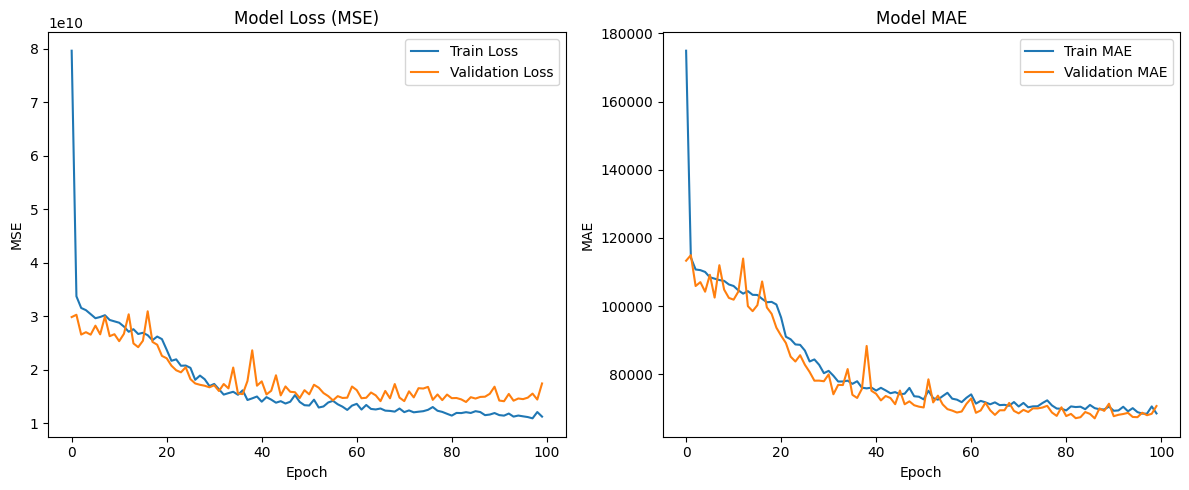

In [6]:
import matplotlib.pyplot as plt

# Plot training curves
plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()


plt.tight_layout()
plt.show()

### Training the best model

Epoch 1/500
541/541 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 159233228800.0000 - mae: 259241.1562 - val_loss: 36287991808.0000 - val_mae: 114757.3125
Epoch 2/500
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 31547348992.0000 - mae: 112814.5781 - val_loss: 35164782592.0000 - val_mae: 116392.6875
Epoch 3/500
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 31018512384.0000 - mae: 110997.8203 - val_loss: 33108789248.0000 - val_mae: 114438.3594
Epoch 4/500
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 31707682816.0000 - mae: 111432.5000 - val_loss: 34397609984.0000 - val_mae: 112177.8359
Epoch 5/500
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 29397692416.0000 - mae: 108738.7188 - val_loss: 33866962944.0000 - val_mae: 116479.9141
Epoch 6/500
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 30640474112.0000 - mae: 109339.4453 - val_loss: 32686747648.0000 - val_mae: 109077.1094
Epoch 7/500
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 30003202048.0000 - mae: 108993.9609 - val_lo

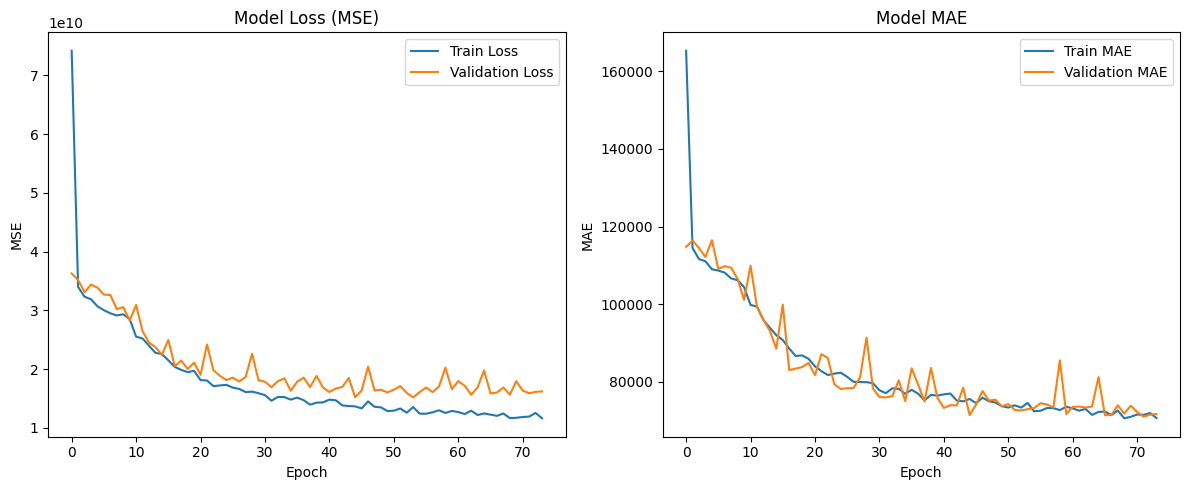

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load dataset
data = pd.read_excel(r'C:\Users\John\Downloads\Universidad\WorkShop0_Tabular_Data/kc_house_data_yr.xlsx')

# Features and target
X = data.drop("price", axis=1).values
y = data["price"].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Build model with best hyperparameters
model = keras.Sequential()
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dropout(0.3))   # dropout after last layer
model.add(layers.Dense(1, activation='linear'))

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train
history = model.fit(
    X, y,
    epochs=500,
    batch_size=32,
    validation_split=0.2,   # still recommended even if you don’t split manually
    callbacks=[early_stop],
    verbose=1
)

# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


Exercise !

- Do the exercise with 3, 5 and 8 trial and report the table for every case !